# Task description
The main task of the state abstraction project consists of a sequential decision task derived from  (from Ott, et al., 2022). The task consists of **trials**, groups of 4 trials constitute a **segment**, and pairs of segments constitute a **segment pair**. In each trials, participants are presented with a reward (in the form of a number, ranging from 1 to 4) that they can either accept or reject. Rejecting the reward results in one more unit of energy. In high costs segment, accepting the reward costs 2 units of energy, in low costs segment, accepting the reward costs only 1 unit. At the beginning of the experiment, participants are given 3 units of energy. Their energy cannot go beyond 6 (i.e. if they reject the reward with 6 energy, their energy remain the same). If energy drops to 0, then they can't accept the reward. In addition, participants are informed on the energy cost of the current segment as well as on the energy cost of the next segment:

<p>
    <center><img src="./experimental_design.jpg" alt></center>
    <center><em>Visualization of the experimental design (from Ott, et al., 2022)</em></center>
</p>

The goal of the participants is to maximize their rewards, but not on every trial but over the duration of the entire experiment. Based on the task settings, maximizing the reward over the entirety of the experiment cannot be achieved by maximizing the rewards in each trial, because if participants were to always accept the reward, they would run out of energy and not be able to accept the next rewards. Therefore, participants must plan ahead and choose actions on each trials as to maximize their rewards in the long run. The goal of this project is to figure out how participants are able to do so efficiently, without requiring extensive training and while minimizing cognitive costs. 

In classical reinforcement learning fashion, this problem is usually approached by formalizing the task as a finite Markov decision process, where each state is defined by:
- $E$: energy level (0 through 6)
- $O$: The set of offer values (1 through 4)
- $CC$: The set of energy cost in the current segment (1 or 2)
- $FC$: The set of energy cost in the future segment (1 or 2)
- $FFC$: The set of energy cost in the next segment pair ([1, 1], [2, 2], [1, 2], [2, 1])

And the actions A can be accept (1) or reject (0). 

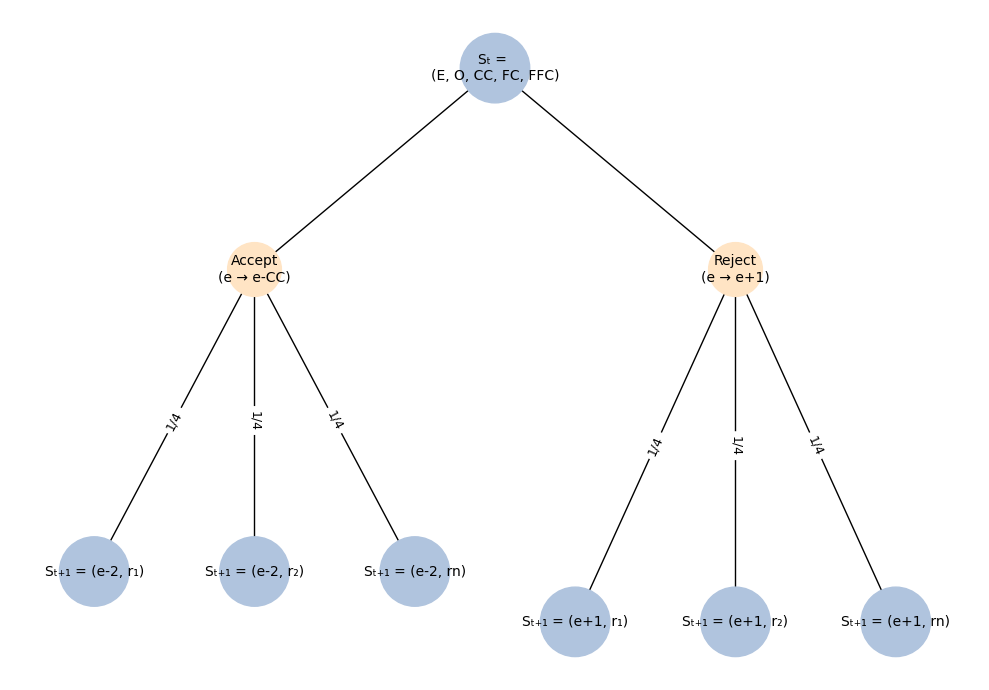

In [1]:
# Generate an MDP diagram for the user's task using matplotlib + networkx
import matplotlib.pyplot as plt
import networkx as nx

# Define states and nodes
G = nx.DiGraph()

# Current state (energy e, shown reward r)
G.add_node("Sₜ = \n(E, O, CC, FC, FFC)")

# Action nodes
G.add_node("Accept\n(e → e-CC)")
G.add_node("Reject\n(e → e+1)")

# Chance outcomes for next reward (uniform over 4)
next_rewards = ["r₁", "r₂", "rn"]

# Next-state nodes for each action
accept_next = [f"Sₜ₊₁ = (e-2, {r})" for r in next_rewards]
reject_next = [f"Sₜ₊₁ = (e+1, {r})" for r in next_rewards]

for n in accept_next + reject_next:
    G.add_node(n)

# Edges from current state to actions
G.add_edge("Sₜ = \n(E, O, CC, FC, FFC)", "Accept\n(e → e-CC)", action="accept")
G.add_edge("Sₜ = \n(E, O, CC, FC, FFC)", "Reject\n(e → e+1)", action="reject")

# Edges from actions to chance outcomes with 1/4 probability labels
for n in accept_next:
    G.add_edge("Accept\n(e → e-CC)", n, prob="1/4")

for n in reject_next:
    G.add_edge("Reject\n(e → e+1)", n, prob="1/4")

# Manual layout for clarity
pos = {
    "Sₜ = \n(E, O, CC, FC, FFC)": (0, 0),
    "Accept\n(e → e-CC)": (-3, -2),
    "Reject\n(e → e+1)": (3, -2),
    accept_next[0]: (-5, -5),
    accept_next[1]: (-3, -5),
    accept_next[2]: (-1, -5),
    reject_next[0]: (1, -5.5),
    reject_next[1]: (3, -5.5),
    reject_next[2]: (5, -5.5),
}
node_color = ["lightsteelblue", "bisque", "bisque", "lightsteelblue", "lightsteelblue", "lightsteelblue", "lightsteelblue", "lightsteelblue", "lightsteelblue"]
node_size = [2500, 1500, 1500, 2500, 2500, 2500, 2500, 2500, 2500, ]
# Draw nodes
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
nx.draw_networkx_labels(G, pos, font_size=10)

# Draw edges
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', arrowsize=15)

# Draw edge labels: probabilities on branches to next states
edge_labels = {(u, v): d.get('prob', '') for u, v, d in G.edges(data=True) if d.get('prob')}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.axis('off')
plt.tight_layout()

These state parameters fully characterize everything the **agent** knows at any given point. In the first trial ($t=1$), the agent knows how much energy it has, what it is currently being offered, the energy cost of accepting a reward in the current segment as well as the energy cost in the upcoming segment. In addition, assuming the agent knows the task, it also knows that in the next segment pair, the energy costs will be either [1, 1], [2, 2], [1, 2] or [2, 1]. In addition, we also know the dynamics of the task, that is the probability to transition from one state to the next: we know that we accept the offer and have sufficient energy to do so, we have 1/4 chance to land in a state with each reward, and that our energy will decrease by the cost and so on. 

The goal of the agent is to select actions to maximize it's reward at the end of the experiment, which is called the value rather than reward as reward refers to the immediate reward. We call the series of actions the agent takes throughout the experiment a policy. A policy gives for each possible state encountered in the experiment the action taken by the agent. And so the goal of the agent is to find the policy that will yield the highest reward. But before we get there, let's write a function that returns the total reward (i.e. return or $Gt$) obtained by the agent given any policy:

In [2]:
import numpy as np

rng = np.random.default_rng()

def gt(policy, E, O, costs, e, e_max=6, n_trials=12, n_trial_per_segment=4):
    """
    Calculate the return over n trials when following a given policy (see https://doi.org/10.1016/j.neuroimage.2022.119222) 
    policy : numpy.ndarray, shape : (n_E, n_O, n_CC * n_FC, n_FFC)
        Policy matrix, defining action to take for each state. Values between 0 and 1, 
        0 being rejecting 
    E : list or 1-D ndarray
        all possible energy levels involved in the experiment
    O : list or 1-D ndarray
        The set of offer values presented in the experiment
    costs : list or 1-D ndarray
        The set of energy costs for segment pairs
    e : float or int
        Initial energy level
    e_max : int, optional
        max energy level
    n_trials : int
        number of triasls
    ntrials_per_segment : int
        Number of trials per segment, defines for how long the cost remains the same
    """
    Gt = 0 # Return
    # Randomly draw the costs:
    cc = rng.choice(costs, size=1)[0]
    fc = rng.choice(costs, size=1)[0]
    ffc = rng.choice(costs, size=1)[0]

    for t in range(n_trials):
        # Check segment costs:
        if t // n_trial_per_segment == 0:
            c = cc
        elif t // n_trial_per_segment == 1: 
            c = fc
        else:
            c = ffc
        # Get trial reward:
        o = rng.choice(O, size=1)[0]
        # Get action from policy:
        a = policy[E.index(e), O.index(o), costs.index(cc), costs.index(fc), t]
        if a == 1:
            if e > c:
                Gt += o
                e -= c
        else:
            if e < e_max:
                e += 1

    return Gt

We can now define a policy (i.e. a set of 1 and 0 that dictate in each state which decision the agent takes) and see how much reward we obtain:

In [3]:
n_trials = 12
E = [0, 1, 2, 3, 4, 5, 6]
O = [1, 2, 3, 4]
costs = [1, 2]
pol_dim = (len(E), len(O), len(costs), len(costs), n_trials)
# Generate 3 policies:
random_policy = np.random.choice([0, 1], size=pol_dim)  # Random policy

# Get the return:
print(gt(random_policy, E, O, costs, 3, e_max=6, n_trials=n_trials, n_trial_per_segment=4))

13


The $Gt$ function give us the total amout of reward we get after one sequence of our experiment, given a specified policy. But this is not particularly helpful. What we want to know is given the state we are currently in, what is the best course of action to get the max amount of reward in the end. In other words, we want to know from that state onward, what is the max amount of reward we can get. This is what is given by the value function. The value function $V_\pi(s)$ tells us given a policy and the state we are currently in, what is the reward we can ultimately get. Formally:

$$V_\pi(s) = \mathop{\mathbb{E}}[G_t|S_t=s] = \mathop{\mathbb{E}}_\pi[\sum_{k=0}^\infty \gamma^kR_{t+k+1}|S_t=s]$$

Where $\gamma$ is the discount factor that decreases the importance of distance rewards. Since in our case, we only care about the final return, we can set $\gamma=1$ and discard it from future computations. We can use the value function to compare policies to find the best ones. Specifically, a policy that yields equal or better values for all states is at least as good or better than the alternative policy (i.e. a policy that has the same values everywhere but a larger value is a single state is better than the alternative policy). The value function can be calculated using the Bellman equation, which defines the value function in recursive terms:

$$V_\pi(s) = \sum_a\pi(a|s)\sum_{s', r}p(s',r|s,a)[r + v_pi(s')]$$

This function is basically saying: the value of the current state is equal to the value and reward of the state we reach at the next time step, divided by the probability of that state and associated action to occur given our policy and the task structure. We can implement a function that will implement this formulae. In our case things are a bit simpler, since we have non-stochastic policy: we either accept or reject. Accordingly, we only need to calculate the value of one or the other:

In [4]:
def value_function(policy, s, t):
    """
    This function computes the value of a state given a policy in a recursive fashion following the Bellman's equation
    """
    # Parameters of the task
    offers = [1, 2, 3, 4]
    n_offer   = len(offers)
    n_trial   = 12
    max_energy= 6

    # Unpack state:
    e, o, cc, fc, ffc = s

    # Terminal state
    if t == n_trial:
        return 0.0

    # Get cost for this trial:
    if t < 4:
        c = cc
    elif t < 8:
        c = fc
    else:
        c = ffc  # from t>=8 the third-segment cost is revealed and fixed

    # Get policy for the current state
    a = policy[e, o-1, cc-1, fc-1, t]

    # Calculate immediate reward energy level of the next trial
    if a == 1:  # accept
        # If we have enough energy
        if e >= c:
            r = o  # Take reward
            e_next = e - c  # Pay price in energy
        else:  # Otherwise
            r = 0  # We get 0 reward
            e_next = 0  # Energy falls to 0
    else:       # reject
        r = 0  # No reward
        e_next = min(max_energy, e + 1)  # Gain 1 energy, capped at 6

    # Special case for the transition from on segment pair to the next
    if t == 7:
        # Crossing into trial 9 next: cost of third segment is still unknown right now,
        # so we average over ffc ∈ {1,2} here (once), then treat it as KNOWN for t>=8.
        exp_next = 0.0
        for o2 in offers:
            v_c1 = value_function(policy, [e_next, o2, cc, fc, 1], t+1)
            v_c2 = value_function(policy, [e_next, o2, cc, fc, 2], t+1)
            exp_next += 0.5 * (v_c1 + v_c2)
        exp_next /= n_offer  # uniform over offers
    else:
        # Normal step: ffc stays whatever it already is (unrevealed dummy before t<8, realized after t>=8)
        vals = []
        for o2 in offers:
            vals.append(value_function(policy, [e_next, o2, cc, fc, ffc], t+1))
        exp_next = sum(vals) / n_offer

    return r + exp_next



With the above function, we can estimate the value of each state exiting in our experiment, given any arbitrary policies:

In [5]:
n_energy = 7  # Levels of energy the agent can have (0 to 6)
n_offer = 4  # How many different offers we have (1, 2, 3, 4)
n_costs = 2  # Costs
n_trial = 12  # Number of trials in a sequence

# Preallocate
v_s = np.zeros([n_energy, n_offer, n_costs, n_costs, n_trial])

# Loop through each state based on a random policy:
random_policy = np.random.choice([0, 1], size=[n_energy, n_offer, n_costs, n_costs, n_trial])  # Random policy

for e in range(n_energy):
    for o in range(n_offer):
        for cc in range(n_costs):
            for fc in range(n_costs):
                for ffc in range(n_costs):
                    for t in range(n_trial):
                        v_s[e, o, cc, fc, t] = value_function(random_policy, [e, o + 1, cc + 1, fc + 1, ffc+1], t)

KeyboardInterrupt: 

The value function gives us for a given policy, what the value of each state is, that is how good it is to be in the current state with regard to our final goal, or put another way yet again, what is the total reward we can expect from this state onward by following the current policy. Finding the best policy corresponds to finding the policy that maximizes the value function in every possible state. 

But the value function doesn't in and of itself tell us how to behave, just how good a state is based on any policy. Something that gets us closer to what we want is the Q function, the action value function. This function tells us given the current policy, how good a given action is for the current state, provided that we follow the policy from there onwards. It is basically the same as above, just with the difference that we iterate over each possible action in each state as well:

In [ ]:
def action_value_function(policy, s, t, a):
    """
    This function computes the state action value function. This tells us how valuable is a particular action in a given state, provided that we follow policy in the next trials
    """
    # Parameters of the task
    offers = [1, 2, 3, 4]
    n_offer   = len(offers)
    n_trial   = 12
    max_energy= 6

    # Unpack state:
    e, o, cc, fc, ffc = s

    # Terminal state
    if t == n_trial:
        return 0.0

    # Get cost for this trial:
    if t < 4:
        c = cc
    elif t < 8:
        c = fc
    else:
        c = ffc  # from t>=8 the third-segment cost is revealed and fixed

    # Calculate immediate reward energy level of the next trial
    if a == 1:  # accept
        # If we have enough energy
        if e >= c:
            r = o  # Take reward
            e_next = e - c  # Pay price in energy
        else:  # Otherwise
            r = 0  # We get 0 reward
            e_next = 0  # Energy falls to 0
    else:       # reject
        r = 0  # No reward
        e_next = min(max_energy, e + 1)  # Gain 1 energy, capped at 6

    # Special case for the transition from on segment pair to the next
    if t == 7:
        # Crossing into trial 9 next: cost of third segment is still unknown right now,
        # so we average over ffc ∈ {1,2} here (once), then treat it as KNOWN for t>=8.
        exp_next = 0.0
        for o2 in offers:
            v_c1 = value_function(policy, [e_next, o2, cc, fc, 1], t+1)
            v_c2 = value_function(policy, [e_next, o2, cc, fc, 2], t+1)
            exp_next += 0.5 * (v_c1 + v_c2)
        exp_next /= n_offer  # uniform over offers
    else:
        # Normal step: ffc stays whatever it already is (unrevealed dummy before t<8, realized after t>=8)
        vals = []
        for o2 in offers:
            vals.append(value_function(policy, [e_next, o2, cc, fc, ffc], t+1))
        exp_next = sum(vals) / n_offer

    return r + exp_next


n_energy = 7  # Levels of energy the agent can have (0 to 6)
n_offer = 4  # How many different offers we have (1, 2, 3, 4)
n_costs = 2  # Costs
n_trial = 12  # Number of trials in a sequence
n_a = 2

# Preallocate
q_s = np.zeros([n_energy, n_offer, n_costs, n_costs, n_trial, n_a])

# Loop through each state based on a random policy:
random_policy = np.random.choice([0, 1], size=[n_energy, n_offer, n_costs, n_costs, n_trial])  # Random policy

for e in range(n_energy):
    for o in range(n_offer):
        for cc in range(n_costs):
            for fc in range(n_costs):
                for ffc in range(n_costs):
                    for t in range(n_trial):
                        for a in range(n_a):
                            q_s[e, o, cc, fc, t, a] = action_value_function(random_policy, [e, o + 1, cc + 1, fc + 1, ffc+1], t, a)

The state action value function opens the door to policy improvement. Basically, it tells us at any given step which of the two possible actions give us more value regardless of what the policy tells us for that specific step, but assuming we follow the policy afterwards. If the one action is better than the other, then it would make sense to perform that action rather than the other and update our policy if that's not already what it's telling us to do. 

The ultimate goal when performing the task is to identify the optimal policy, that is the mapping between states and action that yields the max possible cummulative reward in every case. To do so, we can start from a random policy, then calculate calculate the value function of that policy. Then, we can calculate the state-action value function for that policy. We can then for each state compare whether a given action can yield larger value than what we have in our value function. If there is, then we should update our policy by changing the actions to those that yield higher reward. When we have done so, we have updated our policy to a better policy. But this updated policy isn't yet the optimal policy, it is just a better policy. To find the optimal policy, we need to repeat the process, until we fail to update the policy. This will be when we have reached the optimal policy. 

This approach, while workable can be quite inefficient and depends on the random policy we start with. There is an alternative approach which is called backward induction. The idea is that we start by the final state and compute the state-action value function for that state. We then select the action that yields the largest value, and we update our value function accordingly. We can repeat that process until the first step in our task, and that gives us the optimal policy:

In [ ]:
# Parameters:
energy = [0, 1, 2, 3, 4, 5, 6, 7]
offers = [1, 2, 3, 4]
p_o = 1/len(offers)
current_costs = [1, 2]
future_costs = [1, 2]
actions = [0, 1]
n_trials = 12

# Prepare variables:
v = np.zeros([len(energy), len(offers), n_trials + 1, len(current_costs), len(future_costs)])
q = np.zeros([len(energy), len(offers), n_trials, len(actions), len(current_costs), len(future_costs)])

# Set terminal value:
v[:, :, -1, :, 0] = 0

for e in energy:
    for o in offers:
        for cc in current_costs:
            for fc in future_costs:
                for a in actions:
                    for t in range(n_trials):
                        # Last segment:
                        if t < 4:
                            Qtmp = []
                            for ffc in current_costs:
                                if a == 1:
                                    if e > ffc:
                                        Qtmp.append(np.mean(np.multiply(offers, p_o)) + v[e-ffc, :, n_trials-t, cc-1, fc-1] * p_o)
                                    else:
                                        Qtmp.append(v[0, :, n_trials-t, cc-1, fc-1] * p_o)
                                else:
                                    Qtmp.append(v[np.min([7, e+1]), :, n_trials-t, cc-1, fc-1] * p_o)
                            try:
                                q[e, o-1, t, cc-1, fc-1, a] = np.mean(Qtmp)
                            except:
                                print('A')
                        else:
                            if t < 8:
                                c = fc
                            else:
                                c = cc

                            # Determine next step:
                            if a == 1:  # accept
                                # If we have enough energy
                                if e >= c:
                                    r = o  # Take reward
                                    e_next = e - c  # Pay price in energy
                                else:  # Otherwise
                                    r = 0  # We get 0 reward
                                    e_next = 0  # Energy falls to 0
                            else:       # reject
                                r = 0  # No reward
                                e_next = min(energy[-1], e + 1)  # Gain 1 energy, capped at 6
                            q[e, o-1, t, cc-1, fc-1, a] = np.sum(v[e_next, :, n_trials-t, cc-1, fc-1])
                        # Select the value of the next step as the value of the best action:
                        v[e, o-1, t-1, cc-1, fc-1] = np.maximum(q[e, o-1, t, cc-1, fc-1, 0], q[e, o-1, t, cc-1, fc-1, 1])




In [6]:
'''
TAKEN FROM FLORIAN OTT REPOSITORY FOR COMPARISON PURPOSES!!!
'''


def ara_backward_induction(energy_cost_current = 1,energy_cost_future = 1,energy_bonus = 0):
    """
    This fuction implements the backward induction algorithm.
    The inputs energy_cost_future and energy_cost_current specify the energy 
    costs of the current and future segments. Energy_bonus adjusts the value 
    of the energy units remaining at the end of the planning horizon. 
    """
    
    n_energy                = 7 # number of energy states
    n_offer                 = 4 # number of offers
    n_action                = 2 # number of actions
    n_trial                 = 12 # number of trials 
    max_energy              = 6 # maximum energy state
    op                      = np.array([1/4, 1/4, 1/4, 1/4]) # offer probability
    average_future_reward   = 2.5 # expected offer value
    possible_energy_costs   = np.array([1,2]) # possible energy costs
    
    V = np.zeros((n_energy,n_offer,n_trial+1)) # state value function 
    Q = np.zeros((n_energy,n_offer,n_action,n_trial)) # state action value function
    
    final_reward = np.tile(np.arange(n_energy),(n_offer,1)).T * energy_bonus # terminal reward 
    V[:,:,0] = final_reward
    
    # loop through the statespace and timesteps
    # Note1: If speed is needed, vectorize and use tranision matrix 
    # Note2: Since we are implicitly looping backwards, the future 
    # segment comes first
    for t in range(n_trial):
        for e in range(n_energy):
            for a in range(n_action):               
                for o in range(n_offer):
                      
                    if t < (n_trial-8): # Future beyond the 8th trial.                   
                        Qtmp = np.zeros(2)
                        for i,pec in enumerate(possible_energy_costs): 
                            if a == 0: # accept
                                if e >= pec: # enough energy
                                    Qtmp[i] = average_future_reward + np.sum(V[e-pec,:,t]*op)
                                elif e < pec: # not enough energy
                                    Qtmp[i] = np.sum(V[0,:,t]*op) # energy goes to 0
                            elif a == 1: # reject
                                if e < max_energy: # not max energy
                                    Qtmp[i] = np.sum(V[e+1,:,t]*op)
                                if e == max_energy: # max energy
                                    Qtmp[i] = np.sum(V[e,:,t]*op)
                        Q[e,o,a,t] = np.mean(Qtmp) # Average over potential future segments
    
                    elif (t >= (n_trial-8)) & (t < (n_trial-4)): # Future segment
                        if a == 0: # accept
                            if e >= energy_cost_future: # enough energy
                                Q[e,o,a,t] = o+1 + np.sum(V[e-energy_cost_future,:,t]*op)
                            elif e < energy_cost_future: # not enough energy
                                Q[e,o,a,t] = np.sum(V[0,:,t]*op) # energy goes to 0
                        elif a == 1: # reject
                            if e < max_energy: # not max energy
                                Q[e,o,a,t] = np.sum(V[e+1,:,t]*op)
                            if e == max_energy: # max energy
                                Q[e,o,a,t] = np.sum(V[e,:,t]*op)
                            
                    elif t >= (n_trial-4):  # Current segment 
                        if a == 0: # accept
                            if e >= energy_cost_current: # enough energy
                                Q[e,o,a,t] = o+1 + np.sum(V[e-energy_cost_current,:,t]*op)
                            elif e < energy_cost_current: # not enough energy
                                Q[e,o,a,t] = np.sum(V[0,:,t]*op) # energy goes to 0
                        elif a == 1: # reject
                            if e < max_energy: # not max energy
                                Q[e,o,a,t] = np.sum(V[e+1,:,t]*op)
                            if e == max_energy: # max energy
                                Q[e,o,a,t] = np.sum(V[e,:,t]*op)
                
                    # Value of the maximizing action given energy state e,
                    # offer o and trial t 
                    Qmax = np.maximum(Q[e,o,0,t],Q[e,o,1,t])
                               
                    # Update state value function  
                    V[e,o,t+1] = Qmax
    
    # Flip V and Q such that the first trial corresponds to te first index  
    V = V[:,:,::-1]
    Q = Q[:,:,:,::-1]   

    return V, Q         
            
#%%  Run backward induction
# Calculate decision varaible DV and conflict C
costs = np.array([[1,1], [2,1],[1,2],[2,2]]) 
energy_bonus=0
V = np.zeros((7,4,13,4)) # State-value function 
Q = np.zeros((7,4,2,12,4)) # Stat-action function 
average_future_reward = 2.5

for i in range(4):
    V[:,:,:,i], Q[:,:,:,:,i] = ara_backward_induction(energy_cost_current = costs[i][0],energy_cost_future = costs[i][1],energy_bonus=energy_bonus)
DV = Q[:,:,0,:,:] - Q[:,:,1,:,:] 
C = np.absolute(DV) * -1

To vizualize the decision value, we can plot heatmaps showing the decision value as a function of energy, offer and time point:

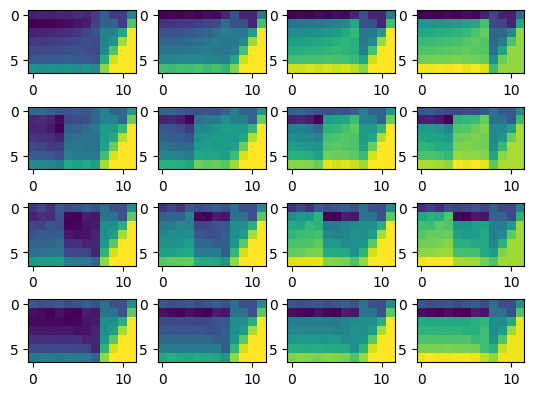

In [7]:
fig, ax = plt.subplots(len(costs), 4)
for y, o in enumerate([1, 2, 3, 4]):
    ctr = 0
    for i, x in enumerate(costs):
        ax[ctr, y].imshow(np.squeeze(DV[:, o-1, :, i]))
        ctr += 1


We will now create a class to play around with the parameters to get the decision values under different experimental conditions

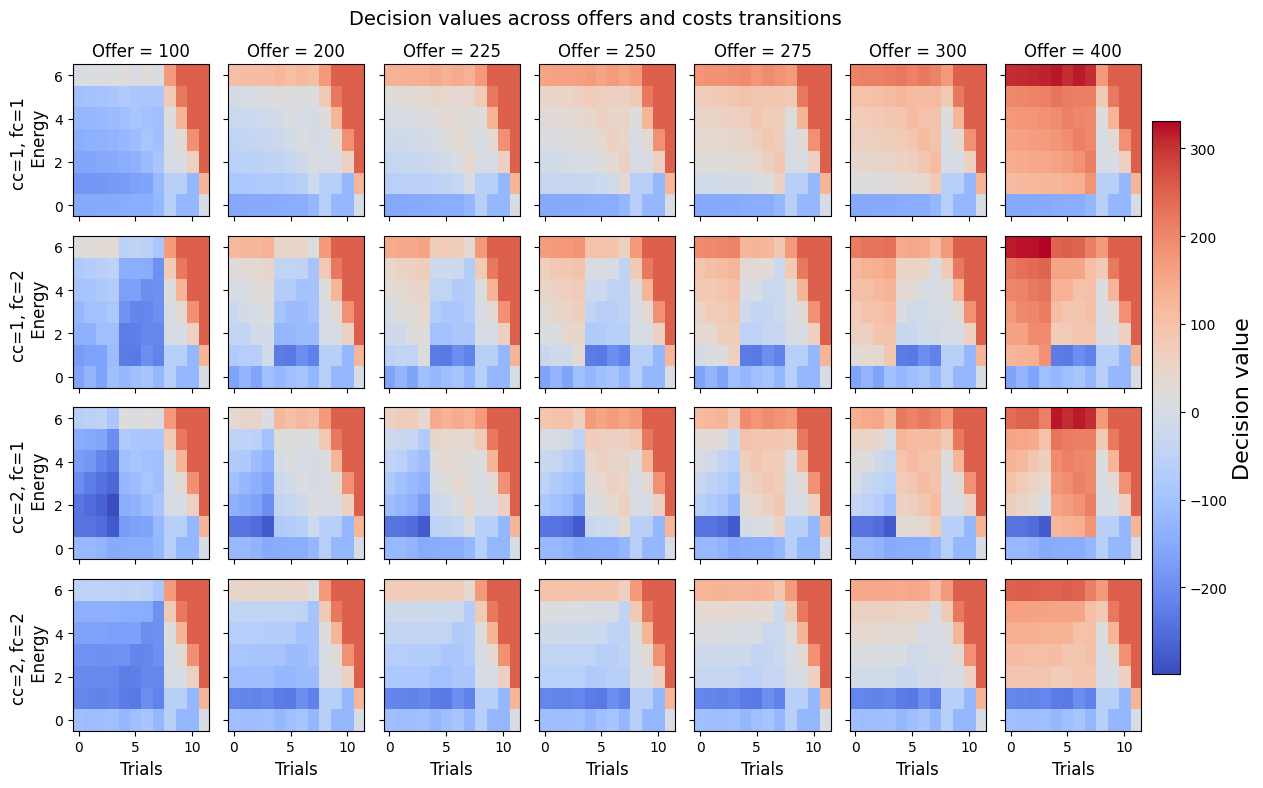

In [ ]:
from dataclasses import dataclass, field
import numpy as np

@dataclass
class TaskConfig:
    """
    This class contains all the parameters related to the task.
    """
    # Structure of the task:
    n_trials_per_segment: int = 4
    tmax: int = 12
    
    # Energy
    initial_energy: int = 3
    max_energy: int = 6
    min_energy = 0

    # Costslist[int] = field(default_factory=lambda: [1, 2, 3])
    costs: list[int] = field(default_factory=lambda: [1, 2])

    # Rewards:
    energy: list[int] = field(default_factory=lambda: [0, 1, 2, 3, 4, 5, 6])
    offers: list[int] = field(default_factory=lambda: [100, 200, 225, 250, 275, 300, 400])
    p_offer: list[int] = field(default_factory=lambda: [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7])

    # Actions:
    actions: list[int] = field(default_factory=lambda: [0, 1])


class DPStateActionValue:
    """
    This class computes the state action value for our problem based on value iteration (i.e. dynamic programming)
    """
    def __init__(self, config: TaskConfig):
        self.DV = None
        # Set task config:
        self.config = config
        # Get dimensions:
        self.n_energy  = len(self.config.energy)  # Number of energy states
        self.n_offers  = len(self.config.offers)  # Number of offers
        self.n_cc      = len(self.config.costs)   # Number of current costs
        self.n_fc      = len(self.config.costs)   # Number of future costs
        self.n_steps   = self.config.tmax         # Number of steps
        self.n_actions = len(self.config.actions) # Number of actions

        # Initialize state-value function
        self.V = np.zeros((self.n_energy, self.n_offers, 
                           self.n_cc, self.n_fc, self.n_steps + 1)) 
        # Initialize state-action value function
        self.Q = np.zeros((self.n_energy, self.n_offers, 
                           self.n_cc, self.n_fc, self.n_steps,
                            self.n_actions)) 
    

    def value_iteration(self):
        """
        This function iterates over states backward in time to compute the optimal value function from the 
        optimal state action value function
        """
        # Set the value of the final step:
        self.V[:, :, :, :, -1] = 0
        # Loop through every step
        for t in reversed(range(self.n_steps)):
            # Loop through each state within each step
            for e_i, e in enumerate(self.config.energy):
                for o_i, o in enumerate(self.config.offers):
                    for cc_i, cc in enumerate(self.config.costs):
                        for fc_i, fc in enumerate(self.config.costs):
                            # Loop through each action in each state
                            for a_i, a in enumerate(self.config.actions):       
                                if t >= self.config.n_trials_per_segment*2: # Future beyond the 8th trial.                   
                                    Qtmp = np.zeros(2)
                                    for i,pec in enumerate(self.config.costs): 
                                        if a == 1: # accept
                                            if e >= pec: # enough energy
                                                Qtmp[i] = np.mean(self.config.offers) + np.sum(self.V[e-pec,:, cc_i, fc_i, t+1]*self.config.p_offer)
                                            elif e < pec: # not enough energy
                                                Qtmp[i] = np.sum(self.V[0,:, cc_i, fc_i, t+1]*self.config.p_offer) # energy goes to 0
                                        elif a == 0: # reject
                                            if e < self.config.max_energy: # not max energy
                                                Qtmp[i] = np.sum(self.V[e+1,:, cc_i, fc_i, t+1]*self.config.p_offer)
                                            if e == self.config.max_energy: # max energy
                                                Qtmp[i] = np.sum(self.V[e,:, cc_i, fc_i, t+1]*self.config.p_offer)
                                    self.Q[e_i, o_i, cc_i, fc_i, t, a_i] = np.mean(Qtmp) # Average over potential future segments
                
                                elif self.config.n_trials_per_segment <= t <  self.config.n_trials_per_segment*2:# Future segment
                                    if a == 1: # accept
                                        if e >= fc: # enough energy
                                            self.Q[e_i, o_i, cc_i, fc_i, t, a_i] = o + np.sum(self.V[e-fc,:, cc_i, fc_i, t+1]*self.config.p_offer)
                                        elif e < fc: # not enough energy
                                            self.Q[e_i, o_i, cc_i, fc_i, t, a_i] = np.sum(self.V[0,:, cc_i, fc_i, t+1]*self.config.p_offer) # energy goes to 0
                                    elif a == 0: # reject
                                        if e < self.config.max_energy: # not max energy
                                            self.Q[e_i, o_i, cc_i, fc_i, t, a_i] = np.sum(self.V[e+1,:, cc_i, fc_i, t+1]*self.config.p_offer)
                                        if e == self.config.max_energy: # max energy
                                            self.Q[e_i, o_i, cc_i, fc_i, t, a_i] = np.sum(self.V[e,:, cc_i, fc_i, t+1]*self.config.p_offer)
                                        
                                elif t < self.config.n_trials_per_segment:  # Current segment 
                                    if a == 1: # accept
                                        if e >= cc: # enough energy
                                            self.Q[e_i, o_i, cc_i, fc_i, t, a_i] = o + np.sum(self.V[e-cc,:, cc_i, fc_i, t+1]*self.config.p_offer)
                                        elif e < cc: # not enough energy
                                            self.Q[e_i, o_i, cc_i, fc_i, t, a_i] = np.sum(self.V[0,:, cc_i, fc_i, t+1]*self.config.p_offer) # energy goes to 0
                                    elif a == 0: # reject
                                        if e < self.config.max_energy: # not max energy
                                            self.Q[e_i, o_i, cc_i, fc_i, t, a_i] = np.sum(self.V[e+1,:, cc_i, fc_i, t+1]*self.config.p_offer)
                                        if e == self.config.max_energy: # max energy
                                            self.Q[e_i, o_i, cc_i, fc_i, t, a_i] = np.sum(self.V[e,:, cc_i, fc_i, t+1]*self.config.p_offer)
                            
                                # Value of the maximizing action given energy state e,
                                # offer o and trial t 
                                Qmax = np.maximum(self.Q[e_i, o_i, cc_i, fc_i, t, 0],self.Q[e_i, o_i, cc_i, fc_i, t, 1])
                                        
                                # Update state value function  
                                self.V[e_i, o_i, cc_i, fc_i, t] = Qmax   
        
    def get_dv(self):
        """
        This function computes the decision value based on the dynamic programming solution
        """
        if not np.any(self.V):
            self.value_iteration()

        self.DV = self.Q[:,:,:,:,:, 1] - self.Q[:,:,:,:,:,0] 

    def plot_dv(self):
        """
        This function plots the decision values
        """
        if self.DV is None:
            self.get_dv()

        fig, ax = plt.subplots(self.n_cc * self.n_fc , self.n_offers, figsize=[12, 8])
        fig.suptitle('Decision values across offers and costs transitions', size=14)
        for o_i, o in enumerate(self.config.offers):
            ctr = 0
            for cc_i, cc in enumerate(self.config.costs):
                for fc_i, fc in enumerate(self.config.costs):
                    im = ax[ctr, o_i].imshow(np.squeeze(self.DV[:, o_i, cc_i, fc_i, :]), aspect='auto',
                                             cmap='seismic', origin='lower', vmin=np.min(self.DV), 
                                             vmax=np.max(self.DV))
                    if ctr == 0:
                        ax[ctr, o_i].set_title(f'Offer = {o}', size=12)
                    if o_i == 0:
                        ax[ctr, o_i].set_ylabel(f'cc={cc}, fc={fc} \n Energy', size=12)
                    else:
                        ax[ctr, o_i].set_yticklabels([])
                    if ctr + 1 == self.n_cc * self.n_fc:
                        ax[ctr, o_i].set_xlabel('Trials', size=12)
                    else:
                        ax[ctr, o_i].set_xticklabels([])

                    ctr += 1
        plt.tight_layout()
        cbar = fig.colorbar(im, ax=ax.ravel().tolist(),fraction=0.025, pad=0.01)
        cbar.ax.set_ylabel('Decision value', size=16)
        
    
    def agent(self, policy, n_trials, starting_e = 3):
        """
        This function plots the decision values:
        """
        e = starting_e

        # Caculate the number of segments:
        n_segments = n_trials // self.config.n_trials_per_segment
        Gt = 0
        for seg in range(n_segments):
        
            # Randomly draw the costs:
            cc = rng.choice(self.config.costs, size=1)[0]
            fc = rng.choice(self.config.costs, size=1)[0]

            for t in range(self.config.n_trials_per_segment * 2):
                # Check segment costs:
                if t < self.config.n_trials_per_segment:
                    c = cc
                elif t >= self.config.n_trials_per_segment:
                    c = fc

                # Get trial reward:
                o = rng.choice(self.config.offers, size=1)[0]
                # Check decision value:
                

                if policy[self.config.energy.index(e), 
                          self.config.offers.index(o), 
                          self.config.costs.index(cc), 
                          self.config.costs.index(fc), t] == 1:
                    if e > c:
                        Gt += o
                        e -= c
                    else:
                        e = 0
                else:
                    if e < self.config.max_energy:
                        e += 1

        return Gt

# Initialize the task:
config = TaskConfig()
# Compute the optimal value and state-action functions:
solver = DPStateActionValue(config)
# Plot the resulting decision values:
solver.plot_dv()


We can now illustrate how an optimal agent (i.e. one that follows decision value to the tee) performs compared to any other agent that follows a less ideal policy:

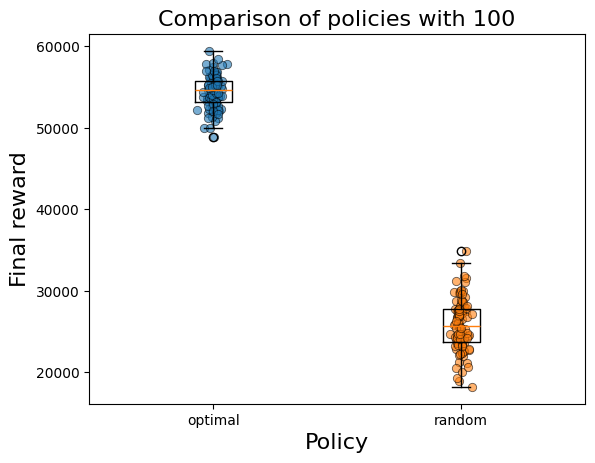

In [9]:
# Determine optimal policy:
optimal_policy = np.zeros(solver.DV.shape)
optimal_policy[solver.DV>0] = 1
# Generate a random policy that picks between 1 and 0:
random_policy =  np.random.choice([0, 1], size=solver.DV.shape)  # Random policy

# Iterate a 100 times to show that the final performance of the optimal policy is always best:
Gt_optimal = []
Gt_random = []

n_iter = 100

for i in range(n_iter):
    Gt_optimal.append(solver.agent(optimal_policy, 240, starting_e = 3))
    Gt_random.append(solver.agent(random_policy, 240, starting_e = 3))

results = np.array([Gt_optimal, Gt_random])
fig, ax = plt.subplots()
ax.scatter(np.random.normal(1, 0.02, size=n_iter), results[0, :], marker='o', edgecolor='k', linewidths=0.6, alpha=0.6)
ax.scatter(np.random.normal(2, 0.02, size=n_iter), results[1, :], marker='o', edgecolor='k', linewidths=0.6, alpha=0.6)
ax.boxplot(results.T, tick_labels=['optimal', 'random'])
ax.set_ylabel('Final reward', size=16)
ax.set_xlabel('Policy', size=16)
ax.set_title(f'Comparison of policies with {n_iter}', size=16)
plt.show()



# Random agent
As a first attempt to program an agent going through the task, I implement the simplest possible policy: randomly choosing between accepting and rejecting the offer on every single trial, regardless of what happens. 

# Bibliography
Ott, F., Legler, E., & Kiebel, S. J. (2022). Forward planning driven by context-dependant conflict processing in anterior cingulate cortex. NeuroImage, 256, 119222. DOI: https://doi.org/10.1016/j.neuroimage.2022.119222